In [25]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all available devices
print("Available Devices: ", tf.config.list_physical_devices())

Num GPUs Available:  0
Available Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Import needed libraries

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tifffile as tiff

# Normalize image

In [2]:
def normalize(img):
    normalized_img = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[-1]):
        band = img[..., i]
        min_val = band.min()
        max_val = band.max()
        normalized_img[..., i] = 2.0 * (band - min_val) / (max_val - min_val) - 1.0
    return normalized_img

# Hot encode function

In [3]:
def one_hot_encode_batch(masks, n_classes):
    batch_size, height, width = masks.shape
    one_hot = np.zeros((batch_size, height, width, n_classes), dtype=np.float32)
    for i in range(n_classes):
        one_hot[..., i] = (masks == i).astype(np.float32)
    return one_hot

# Patches function

In [4]:
def create_patches(image, mask, patch_size):
    img_h, img_w, _ = image.shape
    patches = []
    masks = []
    for i in range(0, img_h, patch_size):
        for j in range(0, img_w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
                masks.append(patch_mask)
    return np.array(patches), np.array(masks)

# Random patch and augment function

In [5]:
def get_rand_patch(img, mask, sz=160):
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    return img[xc:xc+sz, yc:yc+sz], mask[xc:xc+sz, yc:yc+sz]

# Get patches function

In [6]:
def get_patches(x_dict, y_dict, n_patches, sz=160):
    x = []
    y = []
    total_patches = 0
    keys = list(x_dict.keys())
    while total_patches < n_patches:
        img_id = random.sample(keys, 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    x = np.array(x)
    y = np.array(y)
    y_one_hot = one_hot_encode_batch(y, n_classes=8)  # Adjust the number of classes as needed
    return x, y_one_hot

# Model architecture

In [7]:
def unet_model(n_classes=8, input_size=160, input_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.2, 0.3, 0.1, 0.1, 0.3, 0.2, 0.1, 0.1]):
    droprate = 0.25
    n_filters = n_filters_start
    inputs = Input((input_size, input_size, input_channels))
    
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)
    
    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)
    
    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)
    
    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)
    
    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)
    
    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
    
    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)
    
    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)
    
    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)
    
    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)
    
    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Train model function

In [8]:
def train_model(model, x_train, y_train, epochs=10, batch_size=4):
    with tf.device('/GPU:0'):
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Predict on patches Function

In [9]:
def predict(x, model, patch_sz=160, n_classes=8):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for i in range(img_width, extended_width):
        ext_x[:, i, :] = ext_x[:, 2 * img_width - i - 1, :]
    
    prd = model.predict(np.array([ext_x[i * patch_sz:(i + 1) * patch_sz, j * patch_sz:(j + 1) * patch_sz, :]
                                  for i in range(npatches_vertical) for j in range(npatches_horizontal)]))
    prd = prd.reshape((npatches_vertical, npatches_horizontal, patch_sz, patch_sz, n_classes))
    
    full_prd = np.zeros((extended_height, extended_width, n_classes))
    for i in range(npatches_vertical):
        for j in range(npatches_horizontal):
            full_prd[i * patch_sz:(i + 1) * patch_sz, j * patch_sz:(j + 1) * patch_sz, :] = prd[i, j]
    
    return full_prd[:img_height, :img_width, :]

# Train model

In [17]:
# Load and prepare data
image = tiff.imread("C:/Users/Chris/Documents/BCMCA/bcmca_8bands.tif")
mask = tiff.imread("C:/Users/Chris/Documents/BCMCA/bcmca_mask.tif")

# Crop image and mask to the same dimensions
min_height = min(image.shape[0], mask.shape[0])
min_width = min(image.shape[1], mask.shape[1])
image = image[:min_height, :min_width, :8]  # Ensure the image has 8 bands
mask = mask[:min_height, :min_width]

image = normalize(image)
patch_size = 160
n_patches = 5000
x_train, y_train = get_patches({'img1': image}, {'img1': mask}, n_patches, sz=patch_size)

# Instantiate and train model
model = unet_model(n_classes=8, input_size=patch_size, input_channels=8)
trained_model = train_model(model, x_train, y_train, epochs=10, batch_size=4)

# Save the trained model
model_save_path = "C:/Users/Chris/Documents/BCMCA/trained_unet_model_V2"
model.export(model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 890s 700ms/step - accuracy: 0.4213 - loss: 1.4049
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 871s 697ms/step - accuracy: 0.5797 - loss: 1.0402
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 867s 694ms/step - accuracy: 0.6027 - loss: 0.9893
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 860s 688ms/step - accuracy: 0.6329 - loss: 0.9342
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 862s 690ms/step - accuracy: 0.6343 - loss: 0.9201
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 874s 699ms/step - accuracy: 0.6483 - loss: 0.9005
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 879s 703ms/step - accuracy: 0.6504 - loss: 0.8893
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 875s 700ms/step - accuracy: 0.6588 - loss: 0.8722
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 876s 701ms/step - accuracy: 0.6647 - loss: 0.8631
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 879s 703ms/step - accuracy: 0.6608 - loss: 0.8579
INFO:tensorflow:Assets written to: C:/Users/Chris/Documents/BCMCA/trained_unet_

INFO:tensorflow:Assets written to: C:/Users/Chris/Documents/BCMCA/trained_unet_model_V2\assets


Saved artifact at 'C:/Users/Chris/Documents/BCMCA/trained_unet_model_V2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 8), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 160, 160, 8), dtype=tf.float32, name=None)
Captures:
  1951088420496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088422800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088422608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088423568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088424336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088422224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088424528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088424144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088425872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1951088426448: TensorSpec(shape=(), dtype=tf.resource

# Predict on full image

In [10]:
import os
# Predict the mask using the trained model
predicted_mask = predict(image, trained_model, patch_sz=patch_size, n_classes=8)

# Ensure the save directory exists
save_dir = 'C:/Users/Chris/Documents/BCMCA'
os.makedirs(save_dir, exist_ok=True)

# Save the predicted mask as TIFF
tiff.imwrite(os.path.join(save_dir, 'predicted_mask_V2.tif'), predicted_mask)
print(f"Predicted mask saved to {os.path.join(save_dir, 'predicted_mask_V2.tif')}")

NameError: name 'image' is not defined

# Visualize the result

TypeError: Invalid shape (11719, 5, 9922) for image data

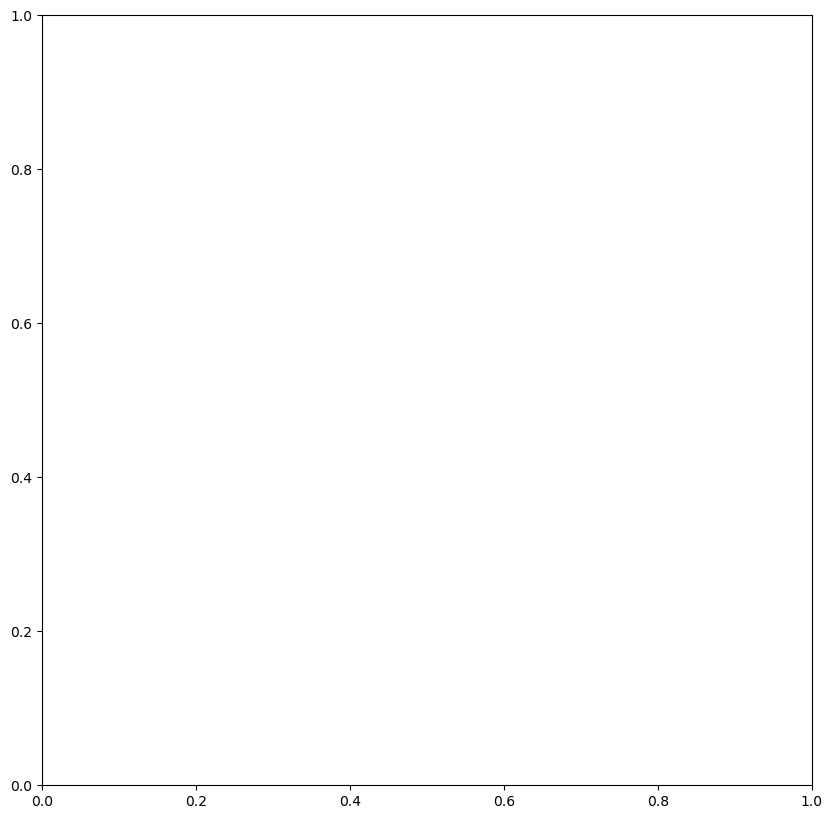

In [12]:
def picture_from_mask(mask, threshold=0.5):
    return (mask > threshold).astype(np.uint8)

fig = plt.figure(figsize=(10, 10))
plt.imshow(picture_from_mask(predicted_mask, threshold=0.5).transpose([1, 2, 0]))
plt.show()

146/146 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step
Predicted mask saved to C:/Users/Chris/Documents/BCMCA\predicted_mask.tif


TypeError: Invalid shape (160, 160, 5) for image data

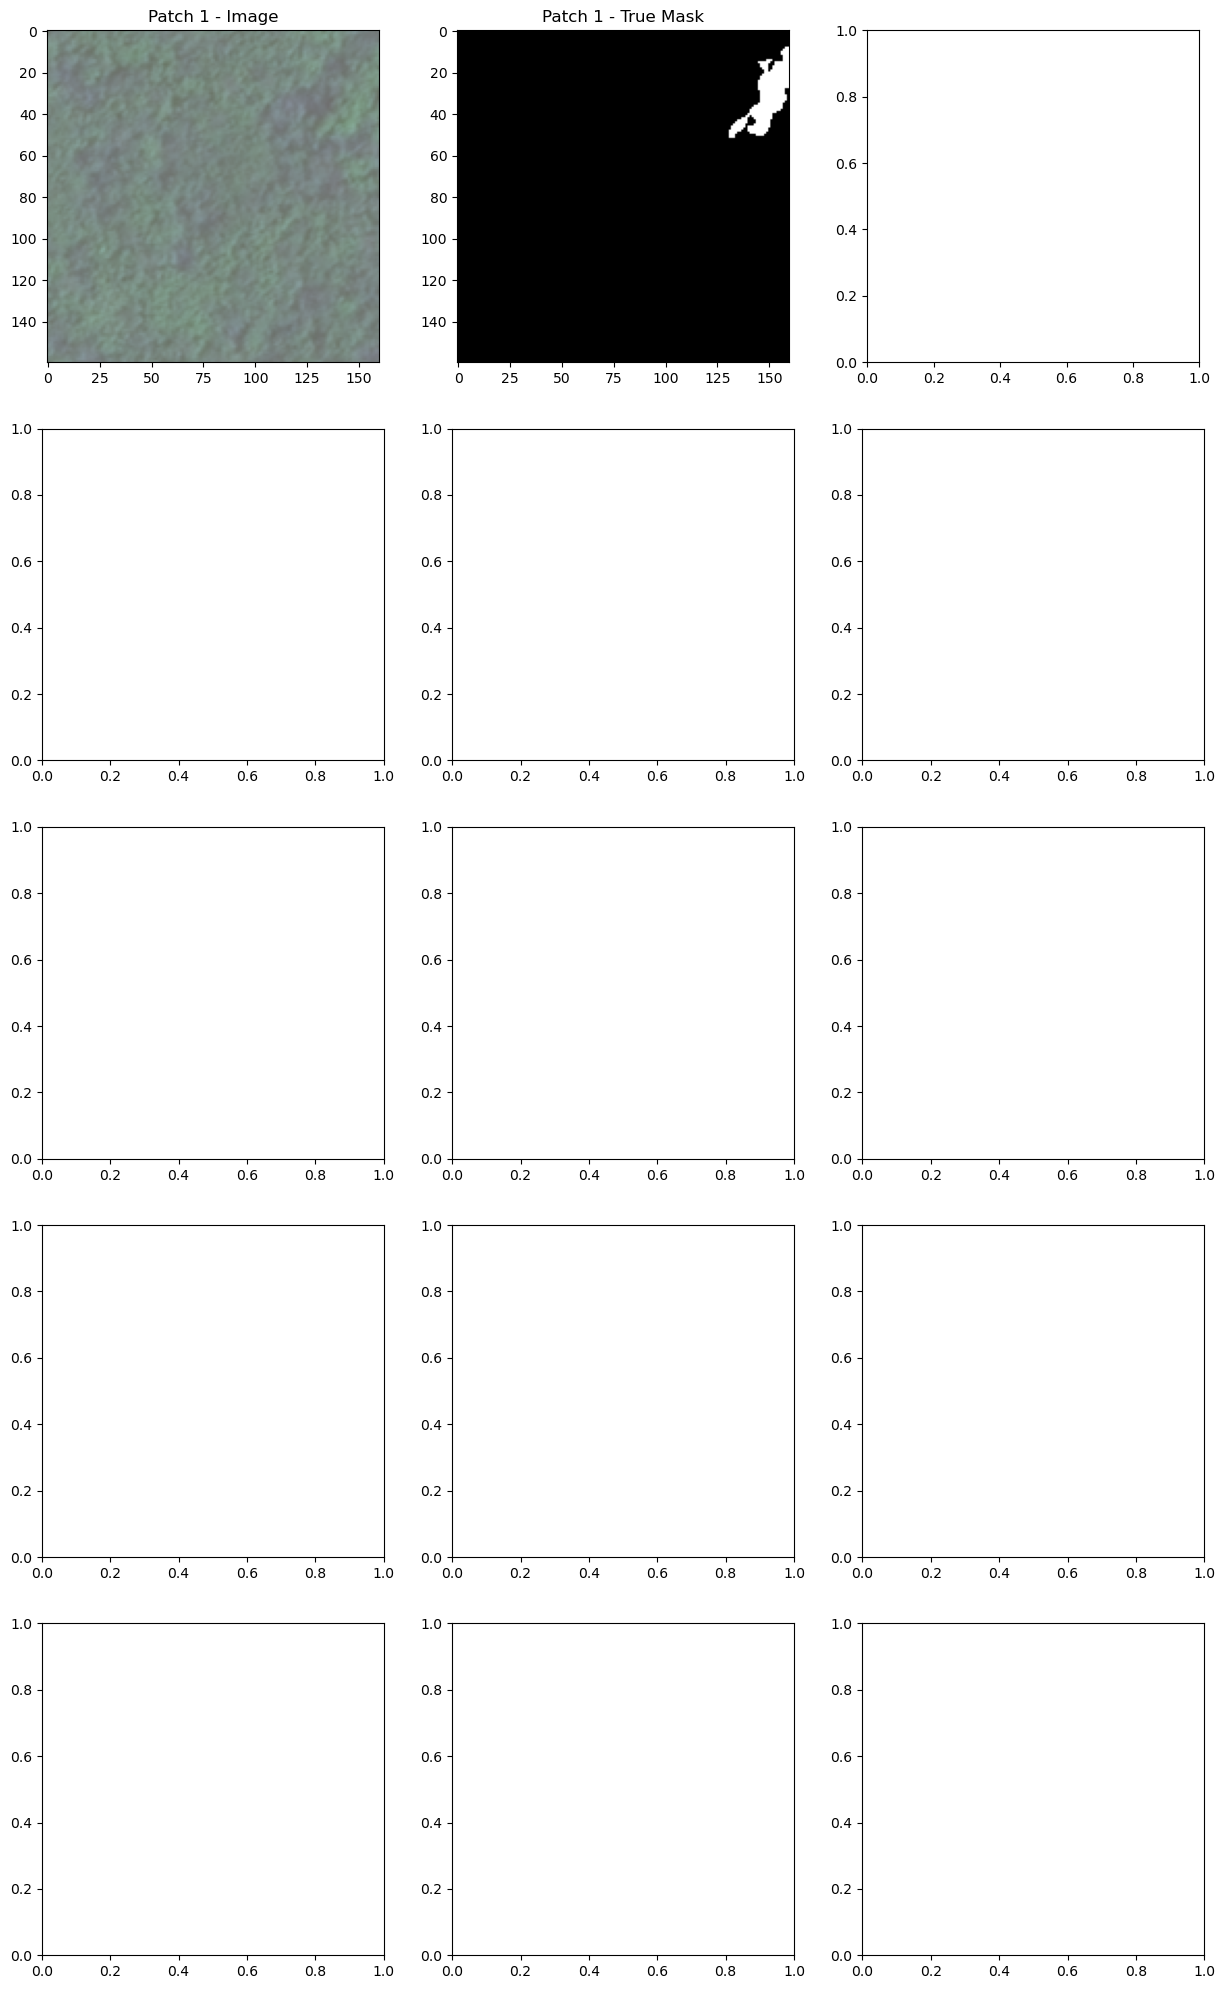

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage import img_as_ubyte

# Function to display a few patches
def display_patches(image, true_mask, predicted_mask, patch_size, n_patches=5):
    # Get the number of patches in the image
    height, width, _ = image.shape
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size

    # Randomly select patches to display
    patch_indices = np.random.choice(num_patches_y * num_patches_x, n_patches, replace=False)

    # Create a figure to display the patches
    fig, axes = plt.subplots(n_patches, 3, figsize=(15, n_patches * 5))
    
    for idx, patch_idx in enumerate(patch_indices):
        # Compute the patch coordinates
        patch_y = (patch_idx // num_patches_x) * patch_size
        patch_x = (patch_idx % num_patches_x) * patch_size
        
        # Extract patches
        img_patch = image[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size, :]
        true_patch = true_mask[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]
        pred_patch = np.argmax(predicted_mask[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size, :], axis=-1)
        
        # Display the patches
        axes[idx, 0].imshow(img_patch)
        axes[idx, 0].set_title(f'Patch {idx+1} - Image')
        axes[idx, 1].imshow(true_patch, cmap='gray')
        axes[idx, 1].set_title(f'Patch {idx+1} - True Mask')
        axes[idx, 2].imshow(pred_patch, cmap='gray')
        axes[idx, 2].set_title(f'Patch {idx+1} - Predicted Mask')
    
    plt.tight_layout()
    plt.show()

# Predict the mask using the trained model
predicted_mask = predict(image, trained_model, patch_sz=patch_size, n_classes=5)

# Ensure the save directory exists
save_dir = 'C:/Users/Chris/Documents/BCMCA'
os.makedirs(save_dir, exist_ok=True)

# Save the predicted mask as TIFF
tiff.imwrite(os.path.join(save_dir, 'predicted_mask.tif'), predicted_mask)
print(f"Predicted mask saved to {os.path.join(save_dir, 'predicted_mask.tif')}")

# Display a few patches
display_patches(image, mask, predicted_mask, patch_size)


In [ ]:
import os
import tensorflow as tf
import tifffile as tiff
import math
import numpy as np

# Load the trained U-Net model using TFSMLayer
model_save_path = 'C:/Users/Chris/Documents/BCMCA/trained_unet_model_V2'
trained_model = tf.keras.layers.TFSMLayer(model_save_path, call_endpoint='serving_default')

# Normalize the image if necessary
def normalize(img):
    return img / 255.0

image = tiff.imread("C:/Users/Chris/Documents/BCMCA/bcmca_8bands.tif")
image = normalize(image)

patch_size = 160

# Predict the mask using the trained model
def predict(x, model, patch_sz, n_classes):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]

    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal

    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    ext_x[:img_height, :img_width, :] = x

    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for i in range(img_width, extended_width):
        ext_x[:, i, :] = ext_x[:, 2 * img_width - i - 1, :]

    # Use the model's call method for inference
    patches = np.array([
        ext_x[i * patch_sz:(i + 1) * patch_sz, j * patch_sz:(j + 1) * patch_sz, :]
        for i in range(npatches_vertical)
        for j in range(npatches_horizontal)
    ])
    
    prd = model(patches)

    prd = prd.numpy().reshape((npatches_vertical, npatches_horizontal, patch_sz, patch_sz, n_classes))

    full_prd = np.zeros((extended_height, extended_width, n_classes), dtype=np.float32)

    for i in range(npatches_vertical):
        for j in range(npatches_horizontal):
            full_prd[i * patch_sz:(i + 1) * patch_sz, j * patch_sz:(j + 1) * patch_sz, :] = prd[i, j]

    return full_prd[:img_height, :img_width, :]

predicted_mask = predict(image, trained_model, patch_sz=patch_size, n_classes=8)

# Ensure the save directory exists
save_dir = 'C:/Users/Chris/Documents/BCMCA'
os.makedirs(save_dir, exist_ok=True)

# Save the predicted mask as TIFF
save_path = os.path.join(save_dir, 'predicted_mask_V2.tif')
tiff.imwrite(save_path, predicted_mask)
print(f"Predicted mask saved to {save_path}")